# Ноутбук c примерами работы со средой  Gym-GPN

##  Загрузка библиотек

In [1]:
import gym
import gym_gpn

In [2]:
from time import sleep
import numpy as np

## Создание объекта среды

In [3]:
env = gym.make('gpn-v0')

In [4]:
# создание инстанста виртуальной АЗС
env.create_thread(token = 'a7bf92fc-2bd6-4ab6-9180-9f403f8d490b')

# Методы среды `gym_gpn`

## `.step()` – запуск среды по шагам (итерациям)

### Один шаг

In [5]:
# Совершение одного шага в среде.
# Среда принимает действие и возвращает кортеж (observation, reward, done, info).
res = env.step(100)
res

({'cost': 35,
  'date_time': '2018-06-01T00:00:00',
  'price': 55.0,
  'volume': 82.43},
 4533.650000000001,
 False,
 {})

In [6]:
# observation
print('date_time: ', res[0]['date_time'])
print('price: ', res[0]['price'])
print('cost: ', res[0]['cost'])
print('volume: ', res[0]['volume'])

# reward, done, info
print('reward: ', res[1])
print('done (flag): ', res[2])
print('additional data: ', res[3])

date_time:  2018-06-01T00:00:00
price:  55.0
cost:  35
volume:  82.43
reward:  4533.650000000001
done (flag):  False
additional data:  {}


## `.reset()` – cброс среды к начальному состоянию

In [7]:
env.reset()
print(env.state)

None


# Пример агентной модели

## Загрузка библиотек

In [8]:
import sys
sys.path.append('./examples/agents/')
from random_walk import RandomWalkAgent

## RandomWalkAgent

In [9]:
agnt = RandomWalkAgent(env.low_price, env.high_price)

In [10]:
# действие
agnt.act()

40

In [11]:
# ts = []
# for i in range(11):
#     env.reset()
#     done = env.done
#     while not done:
#         try:
#             price = agnt.act()
#             ob, reward, done, _ = env.step(35+i*2)
#             ts.append([ob, reward])
#         except:
#             continue

# import pickle
# with open('all_data.pkl', 'wb') as f:
#     pickle.dump(ts, f)

# env.cum_reward

# Visualize some data

In [12]:
import pickle
with open('all_data.pkl', 'rb') as f:
    ts = pickle.load(f)

In [13]:
import pandas as pd

In [14]:
X = []
for el in ts:
    X.append(el[0])

In [15]:
X = pd.DataFrame.from_dict(X)

In [16]:
X.drop(columns  = ['cost'], inplace = True)

In [17]:
X.date_time = pd.to_datetime(X.date_time)

In [18]:
X['reward'] = X.price.values * X.volume.values

In [19]:
X['year'] = X['date_time'].map(lambda x: x.year)

In [20]:
X['month'] = X['date_time'].map(lambda x: x.month)

In [21]:
X['day'] = X['date_time'].map(lambda x: x.day)

In [22]:
X['hour'] = X['date_time'].map(lambda x: x.hour)

In [23]:
X.head()

date_time  price  volume   reward  year  month  day  hour
0 2018-06-01 00:00:00   35.0   97.40  3409.00  2018      6    1     0
1 2018-06-01 01:00:00   35.0   63.62  2226.70  2018      6    1     1
2 2018-06-01 02:00:00   35.0   48.93  1712.55  2018      6    1     2
3 2018-06-01 03:00:00   35.0   46.60  1631.00  2018      6    1     3
4 2018-06-01 04:00:00   35.0   59.42  2079.70  2018      6    1     4

In [24]:
df_max = X.groupby('date_time', as_index = False).apply(lambda x: x.loc[x.reward == x.reward.max()])

In [25]:
df_max.index = df_max.index.droplevel()

In [26]:
df_max.reset_index(drop = True, inplace = True)

In [27]:
df_max['day_of_week'] = df_max['date_time'].apply(lambda x: x.dayofweek)

In [28]:
data = df_max.drop(columns = ['date_time', 'volume', 'reward', 'year'])

In [29]:
data = data.loc[data.drop(columns = ['price']).drop_duplicates().index, :]

In [30]:
data.head()

price  month  day  hour  day_of_week
0   55.0      6    1     0            4
1   55.0      6    1     1            4
2   55.0      6    1     2            4
3   55.0      6    1     3            4
4   55.0      6    1     4            4

In [31]:
from sklearn.model_selection import train_test_split as tts

X_train, y_train = data.loc[:1345, :].drop(columns = ['price']), data.loc[:1345, :].price.values
X_test, y_test = data.loc[1345:, :].drop(columns = ['price']), data.loc[1345:, :].price.values
from catboost import CatBoostRegressor

tree = CatBoostRegressor(iterations= 1000, learning_rate= 0.03, depth=2)
tree.fit(X_train, y_train, cat_features=[0,1,2,3], eval_set=[(X_test, y_test)], plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 52.8147894	test: 52.7954592	best: 52.7954592 (0)	total: 54.3ms	remaining: 54.2s
1:	learn: 51.2434372	test: 51.2232597	best: 51.2232597 (1)	total: 60.4ms	remaining: 30.1s
2:	learn: 49.7182732	test: 49.6960436	best: 49.6960436 (2)	total: 65.5ms	remaining: 21.8s
3:	learn: 48.2395646	test: 48.2151039	best: 48.2151039 (3)	total: 71.1ms	remaining: 17.7s
4:	learn: 46.8022468	test: 46.7780927	best: 46.7780927 (4)	total: 76.2ms	remaining: 15.2s
5:	learn: 45.4081566	test: 45.3843186	best: 45.3843186 (5)	total: 80.9ms	remaining: 13.4s
6:	learn: 44.0589486	test: 44.0334126	best: 44.0334126 (6)	total: 84.8ms	remaining: 12s
7:	learn: 42.7474020	test: 42.7222016	best: 42.7222016 (7)	total: 87.7ms	remaining: 10.9s
8:	learn: 41.4781614	test: 41.4552617	best: 41.4552617 (8)	total: 91ms	remaining: 10s
9:	learn: 40.2443186	test: 40.2217752	best: 40.2217752 (9)	total: 94.3ms	remaining: 9.33s
10:	learn: 39.0533670	test: 39.0273651	best: 39.0273651 (10)	total: 98.1ms	remaining: 8.82s
11:	learn: 37.

95:	learn: 4.3940041	test: 4.4701482	best: 4.4701482 (95)	total: 436ms	remaining: 4.1s
96:	learn: 4.3351176	test: 4.4129623	best: 4.4129623 (96)	total: 441ms	remaining: 4.1s
97:	learn: 4.2793112	test: 4.3586965	best: 4.3586965 (97)	total: 445ms	remaining: 4.1s
98:	learn: 4.2257672	test: 4.3068056	best: 4.3068056 (98)	total: 449ms	remaining: 4.09s
99:	learn: 4.1748622	test: 4.2573040	best: 4.2573040 (99)	total: 454ms	remaining: 4.09s
100:	learn: 4.1262754	test: 4.2103170	best: 4.2103170 (100)	total: 459ms	remaining: 4.08s
101:	learn: 4.0801238	test: 4.1661393	best: 4.1661393 (101)	total: 463ms	remaining: 4.08s
102:	learn: 4.0361122	test: 4.1236564	best: 4.1236564 (102)	total: 467ms	remaining: 4.06s
103:	learn: 3.9942531	test: 4.0832929	best: 4.0832929 (103)	total: 469ms	remaining: 4.04s
104:	learn: 3.9543131	test: 4.0454386	best: 4.0454386 (104)	total: 473ms	remaining: 4.03s
105:	learn: 3.9164858	test: 4.0090339	best: 4.0090339 (105)	total: 476ms	remaining: 4.01s
106:	learn: 3.8806282	t

204:	learn: 2.9763713	test: 3.1129039	best: 3.1129039 (204)	total: 815ms	remaining: 3.16s
205:	learn: 2.9745016	test: 3.1121955	best: 3.1121955 (205)	total: 819ms	remaining: 3.16s
206:	learn: 2.9741726	test: 3.1120775	best: 3.1120775 (206)	total: 824ms	remaining: 3.16s
207:	learn: 2.9740764	test: 3.1119452	best: 3.1119452 (207)	total: 829ms	remaining: 3.16s
208:	learn: 2.9728563	test: 3.1107383	best: 3.1107383 (208)	total: 834ms	remaining: 3.15s
209:	learn: 2.9716456	test: 3.1092332	best: 3.1092332 (209)	total: 837ms	remaining: 3.15s
210:	learn: 2.9704876	test: 3.1078945	best: 3.1078945 (210)	total: 839ms	remaining: 3.14s
211:	learn: 2.9684059	test: 3.1060060	best: 3.1060060 (211)	total: 841ms	remaining: 3.13s
212:	learn: 2.9668724	test: 3.1049279	best: 3.1049279 (212)	total: 842ms	remaining: 3.11s
213:	learn: 2.9660283	test: 3.1036106	best: 3.1036106 (213)	total: 844ms	remaining: 3.1s
214:	learn: 2.9647688	test: 3.1024746	best: 3.1024746 (214)	total: 846ms	remaining: 3.09s
215:	learn:

313:	learn: 2.9272950	test: 3.0819479	best: 3.0814709 (298)	total: 1.2s	remaining: 2.62s
314:	learn: 2.9271906	test: 3.0819172	best: 3.0814709 (298)	total: 1.2s	remaining: 2.62s
315:	learn: 2.9271186	test: 3.0818971	best: 3.0814709 (298)	total: 1.21s	remaining: 2.61s
316:	learn: 2.9269427	test: 3.0818841	best: 3.0814709 (298)	total: 1.21s	remaining: 2.61s
317:	learn: 2.9267756	test: 3.0818795	best: 3.0814709 (298)	total: 1.22s	remaining: 2.61s
318:	learn: 2.9266044	test: 3.0818748	best: 3.0814709 (298)	total: 1.22s	remaining: 2.6s
319:	learn: 2.9263153	test: 3.0819699	best: 3.0814709 (298)	total: 1.22s	remaining: 2.59s
320:	learn: 2.9262546	test: 3.0819644	best: 3.0814709 (298)	total: 1.22s	remaining: 2.58s
321:	learn: 2.9258963	test: 3.0820434	best: 3.0814709 (298)	total: 1.22s	remaining: 2.58s
322:	learn: 2.9257799	test: 3.0820478	best: 3.0814709 (298)	total: 1.22s	remaining: 2.57s
323:	learn: 2.9257494	test: 3.0820729	best: 3.0814709 (298)	total: 1.23s	remaining: 2.56s
324:	learn: 2

429:	learn: 2.9138401	test: 3.0841523	best: 3.0814709 (298)	total: 1.58s	remaining: 2.1s
430:	learn: 2.9137783	test: 3.0842436	best: 3.0814709 (298)	total: 1.59s	remaining: 2.09s
431:	learn: 2.9136883	test: 3.0843940	best: 3.0814709 (298)	total: 1.59s	remaining: 2.09s
432:	learn: 2.9136453	test: 3.0843302	best: 3.0814709 (298)	total: 1.59s	remaining: 2.09s
433:	learn: 2.9136407	test: 3.0843592	best: 3.0814709 (298)	total: 1.6s	remaining: 2.08s
434:	learn: 2.9134473	test: 3.0843785	best: 3.0814709 (298)	total: 1.6s	remaining: 2.08s
435:	learn: 2.9134056	test: 3.0844569	best: 3.0814709 (298)	total: 1.61s	remaining: 2.08s
436:	learn: 2.9134030	test: 3.0844704	best: 3.0814709 (298)	total: 1.61s	remaining: 2.08s
437:	learn: 2.9131637	test: 3.0845936	best: 3.0814709 (298)	total: 1.62s	remaining: 2.07s
438:	learn: 2.9130116	test: 3.0846244	best: 3.0814709 (298)	total: 1.62s	remaining: 2.07s
439:	learn: 2.9129075	test: 3.0846449	best: 3.0814709 (298)	total: 1.62s	remaining: 2.07s
440:	learn: 2

549:	learn: 2.9041440	test: 3.0885783	best: 3.0814709 (298)	total: 1.95s	remaining: 1.6s
550:	learn: 2.9041215	test: 3.0885844	best: 3.0814709 (298)	total: 1.96s	remaining: 1.59s
551:	learn: 2.9041092	test: 3.0886088	best: 3.0814709 (298)	total: 1.96s	remaining: 1.59s
552:	learn: 2.9040940	test: 3.0886046	best: 3.0814709 (298)	total: 1.96s	remaining: 1.59s
553:	learn: 2.9040649	test: 3.0884739	best: 3.0814709 (298)	total: 1.97s	remaining: 1.58s
554:	learn: 2.9040443	test: 3.0885214	best: 3.0814709 (298)	total: 1.97s	remaining: 1.58s
555:	learn: 2.9040324	test: 3.0885437	best: 3.0814709 (298)	total: 1.98s	remaining: 1.58s
556:	learn: 2.9039450	test: 3.0885188	best: 3.0814709 (298)	total: 1.98s	remaining: 1.58s
557:	learn: 2.9039226	test: 3.0885279	best: 3.0814709 (298)	total: 1.99s	remaining: 1.57s
558:	learn: 2.9036966	test: 3.0884848	best: 3.0814709 (298)	total: 1.99s	remaining: 1.57s
559:	learn: 2.9034685	test: 3.0886357	best: 3.0814709 (298)	total: 2s	remaining: 1.57s
560:	learn: 2.

652:	learn: 2.8962558	test: 3.0815438	best: 3.0814709 (298)	total: 2.34s	remaining: 1.24s
653:	learn: 2.8962405	test: 3.0815482	best: 3.0814709 (298)	total: 2.34s	remaining: 1.24s
654:	learn: 2.8962391	test: 3.0815492	best: 3.0814709 (298)	total: 2.35s	remaining: 1.24s
655:	learn: 2.8961979	test: 3.0815705	best: 3.0814709 (298)	total: 2.35s	remaining: 1.23s
656:	learn: 2.8961032	test: 3.0810408	best: 3.0810408 (656)	total: 2.35s	remaining: 1.23s
657:	learn: 2.8959943	test: 3.0810834	best: 3.0810408 (656)	total: 2.36s	remaining: 1.23s
658:	learn: 2.8959931	test: 3.0810841	best: 3.0810408 (656)	total: 2.36s	remaining: 1.22s
659:	learn: 2.8959746	test: 3.0810911	best: 3.0810408 (656)	total: 2.37s	remaining: 1.22s
660:	learn: 2.8958844	test: 3.0805790	best: 3.0805790 (660)	total: 2.37s	remaining: 1.22s
661:	learn: 2.8958329	test: 3.0806428	best: 3.0805790 (660)	total: 2.37s	remaining: 1.21s
662:	learn: 2.8956143	test: 3.0806977	best: 3.0805790 (660)	total: 2.38s	remaining: 1.21s
663:	learn

783:	learn: 2.8867970	test: 3.0791587	best: 3.0787752 (738)	total: 2.72s	remaining: 749ms
784:	learn: 2.8867385	test: 3.0792690	best: 3.0787752 (738)	total: 2.72s	remaining: 746ms
785:	learn: 2.8866413	test: 3.0796029	best: 3.0787752 (738)	total: 2.73s	remaining: 743ms
786:	learn: 2.8866287	test: 3.0796083	best: 3.0787752 (738)	total: 2.73s	remaining: 740ms
787:	learn: 2.8865928	test: 3.0796523	best: 3.0787752 (738)	total: 2.74s	remaining: 736ms
788:	learn: 2.8865461	test: 3.0796087	best: 3.0787752 (738)	total: 2.74s	remaining: 733ms
789:	learn: 2.8864986	test: 3.0796089	best: 3.0787752 (738)	total: 2.74s	remaining: 729ms
790:	learn: 2.8864685	test: 3.0796047	best: 3.0787752 (738)	total: 2.75s	remaining: 726ms
791:	learn: 2.8864667	test: 3.0796085	best: 3.0787752 (738)	total: 2.75s	remaining: 723ms
792:	learn: 2.8864571	test: 3.0796927	best: 3.0787752 (738)	total: 2.75s	remaining: 719ms
793:	learn: 2.8864482	test: 3.0797748	best: 3.0787752 (738)	total: 2.75s	remaining: 715ms
794:	learn

898:	learn: 2.8813117	test: 3.0784341	best: 3.0777780 (880)	total: 3.09s	remaining: 347ms
899:	learn: 2.8812728	test: 3.0784429	best: 3.0777780 (880)	total: 3.09s	remaining: 344ms
900:	learn: 2.8812084	test: 3.0785578	best: 3.0777780 (880)	total: 3.1s	remaining: 341ms
901:	learn: 2.8811468	test: 3.0786706	best: 3.0777780 (880)	total: 3.1s	remaining: 337ms
902:	learn: 2.8811455	test: 3.0786719	best: 3.0777780 (880)	total: 3.11s	remaining: 334ms
903:	learn: 2.8811437	test: 3.0786737	best: 3.0777780 (880)	total: 3.11s	remaining: 330ms
904:	learn: 2.8810746	test: 3.0782112	best: 3.0777780 (880)	total: 3.12s	remaining: 327ms
905:	learn: 2.8810090	test: 3.0777630	best: 3.0777630 (905)	total: 3.12s	remaining: 324ms
906:	learn: 2.8809848	test: 3.0777706	best: 3.0777630 (905)	total: 3.12s	remaining: 320ms
907:	learn: 2.8809839	test: 3.0777728	best: 3.0777630 (905)	total: 3.12s	remaining: 316ms
908:	learn: 2.8809721	test: 3.0778313	best: 3.0777630 (905)	total: 3.12s	remaining: 313ms
909:	learn: 

In [32]:
preds = tree.predict(X_test)

In [ ]:
env = gym.make('gpn-v0')
env.create_thread(token='df133af2-dccb-4f06-b31f-bf99c02b1ba9')

done = env.done
i = 0
while not done:
    try:
        price = preds[i]
        if price > 55:
            price = 55
        ob, reward, done, _ = env.step(price)
        print(str(ob['date_time']) + ',' + str(env.cum_reward) + ',' + str(price))
        i+=1
    except:
        continue

2018-07-27T00:00:00,4925.3368,54.52188637774465
2018-07-27T01:00:00,8397.892,54.476844835397344
2018-07-27T02:00:00,11233.0312,54.476844835397344
2018-07-27T03:00:00,13500.745599999998,54.46403438843726
2018-07-27T04:00:00,15844.703999999998,54.46403438843726
2018-07-27T05:00:00,19783.5378,54.09396231034766
2018-07-27T06:00:00,32780.2866,54.476844835397344
2018-07-27T07:00:00,56932.360199999996,54.476844835397344
2018-07-27T08:00:00,87199.5944,54.46403438843726
2018-07-27T09:00:00,116514.8678,54.46403438843726
2018-07-27T10:00:00,142631.4368,53.31171152131765
2018-07-27T11:00:00,164926.8162,54.46403438843726
2018-07-27T12:00:00,184799.7294,54.530402270622524
2018-07-27T13:00:00,210485.52730000002,54.70834476815085
2018-07-27T14:00:00,244037.76570000002,54.63990278722386
2018-07-27T15:00:00,282244.91490000003,54.50842027980767
2018-07-27T16:00:00,315966.13970000006,54.43997829888068
2018-07-27T17:00:00,344775.4797000001,54.46403438843726
2018-07-27T18:00:00,371263.65570000006,54.4768448

In [37]:
done = env.done
i = 0
while not done:
    try:
        price = preds[i]
        if price > 53:
            price = 55
        ob, reward, done, _ = env.step(price)
        print(str(ob['date_time']) + ',' + str(env.cum_reward) + ',' + str(price))
        i+=1
    except:
        continue

In [44]:
env.cum_reward

12510338.255099993

# Ниже все очень грязно, не смотрите туда

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [22]:
def func(x):
    arr =x['reward'].values - x['reward'].loc[x.price == 55].values[0]
    x['flag'] = all(i <= 0 for i in arr)
    return x

In [23]:
def func1(x):
    max = -1
    for i in range(len(x.reward.values)):
        for j in range(i+1, len(x.reward.values)):
            if max < abs(x.reward.values[i] - x.reward.values[j]):
                max = abs(x.reward.values[i] - x.reward.values[j])
    max_arr = []
    for i in range(len(x)):
        max_arr.append(max)
    x['max_diff'] = max_arr
    return x

In [24]:
max_diff = X.groupby(['date_time'], as_index = False).apply(func1)

In [25]:
grouped = max_diff.groupby(['date_time'], as_index = False).apply(func)

In [26]:
group = max_diff.loc[max_diff.date_time.isin(grouped.loc[grouped.flag == False].date_time.unique())].groupby(['date_time'], as_index = False)



In [27]:
best_not_55 = group.apply(lambda x: x.loc[x.reward.argmax, :])

/Users/alexeydomrachev/anaconda3/lib/python3.6/site-packages/pandas/core/common.py:408: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return maybe_callable(obj, **kwargs)


In [28]:
ddf =best_not_55.drop(columns = best_not_55.columns[1:])

In [29]:
ddf['flag'] = np.ones((len(best_not_55), 1))

In [30]:
df_flag = pd.merge(max_diff, ddf, on=['date_time'], how = 'left').fillna(0)

In [76]:
df_flag

date_time  price  volume    reward  year  month  day  hour  \
0     2018-06-01 00:00:00   35.0   97.40   3409.00  2018      6    1     0   
1     2018-06-01 01:00:00   35.0   63.62   2226.70  2018      6    1     1   
2     2018-06-01 02:00:00   35.0   48.93   1712.55  2018      6    1     2   
3     2018-06-01 03:00:00   35.0   46.60   1631.00  2018      6    1     3   
4     2018-06-01 04:00:00   35.0   59.42   2079.70  2018      6    1     4   
5     2018-06-01 05:00:00   35.0  119.78   4192.30  2018      6    1     5   
6     2018-06-01 06:00:00   35.0  290.47  10166.45  2018      6    1     6   
7     2018-06-01 07:00:00   35.0  521.05  18236.75  2018      6    1     7   
8     2018-06-01 08:00:00   35.0  696.80  24388.00  2018      6    1     8   
9     2018-06-01 09:00:00   35.0  757.04  26496.40  2018      6    1     9   
10    2018-06-01 10:00:00   35.0  746.40  26124.00  2018      6    1    10   
11    2018-06-01 11:00:00   35.0  742.69  25994.15  2018      6    1    11   
12    2018-06-01 12:00:00   35.0  688.77  24106.95  2018      6    1    12   
13    2018-06-01 13:00:00   35.0  572.52  20038.20  2018      6    1    13   
14    2018-06-01 14:00:00   35.0  501.14  17539.90  2018      6    1    14   
15    2018-06-01 15:00:00   35.0  436.40  15274.00  2018      6    1    15   
16    2018-06-01 16:00:00   35.0  450.85  15779.75  2018      6    1    16   
17    2018-06-01 17:00:00   35.0  531.28  18594.80  2018      6    1    17   
18    2018-06-01 18:00:00   35.0  650.84  22779.40  2018      6    1    18   
19    2018-06-01 19:00:00   35.0  710.68  24873.80  2018      6    1    19   
20    2018-06-01 20:00:00   35.0  639.01  22365.35  2018      6    1    20   
21    2018-06-01 21:00:00   35.0  527.16  18450.60  2018      6    1    21   
22    2018-06-01 22:00:00   35.0  384.88  13470.80  2018      6    1    22   
23    2018-06-01 23:00:00   35.0  243.68   8528.80  2018      6    1    23   
24    2018-06-02 00:00:00   35.0  126.70   4434.50  2018      6    2     0   
25    2018-06-02 01:00:00   35.0   75.82   2653.70  2018      6    2     1   
26    2018-06-02 02:00:00   35.0   46.75   1636.25  2018      6    2     2   
27    2018-06-02 03:00:00   35.0   43.30   1515.50  2018      6    2     3   
28    2018-06-02 04:00:00   35.0   56.08   1962.80  2018      6    2     4   
29    2018-06-02 05:00:00   35.0  106.45   3725.75  2018      6    2     5   
...                   ...    ...     ...       ...   ...    ...  ...   ...   
22157 2018-08-22 19:00:00   55.0  449.98  24748.90  2018      8   22    19   
22158 2018-08-22 20:00:00   55.0  364.96  20072.80  2018      8   22    20   
22159 2018-08-22 21:00:00   55.0  299.06  16448.30  2018      8   22    21   
22160 2018-08-22 22:00:00   55.0  195.60  10758.00  2018      8   22    22   
22161 2018-08-22 23:00:00   55.0  154.50   8497.50  2018      8   22    23   
22162 2018-08-23 00:00:00   55.0  141.59   7787.45  2018      8   23     0   
22163 2018-08-23 01:00:00   55.0  100.96   5552.80  2018      8   23     1   
22164 2018-08-23 02:00:00   55.0   80.03   4401.65  2018      8   23     2   
22165 2018-08-23 03:00:00   55.0   68.49   3766.95  2018      8   23     3   
22166 2018-08-23 04:00:00   55.0   64.12   3526.60  2018      8   23     4   
22167 2018-08-23 05:00:00   55.0   69.01   3795.55  2018      8   23     5   
22168 2018-08-23 06:00:00   55.0  111.68   6142.40  2018      8   23     6   
22169 2018-08-23 07:00:00   55.0  201.70  11093.50  2018      8   23     7   
22170 2018-08-23 08:00:00   55.0  297.06  16338.30  2018      8   23     8   
22171 2018-08-23 09:00:00   55.0  358.89  19738.95  2018      8   23     9   
22172 2018-08-23 10:00:00   55.0  402.06  22113.30  2018      8   23    10   
22173 2018-08-23 11:00:00   55.0  439.12  24151.60  2018      8   23    11   
22174 2018-08-23 12:00:00   55.0  522.71  28749.05  2018      8   23    12   
22175 2018-08-23 13:00:00   55.0  581.46  31980.30  2018      8   23    13   
22176 2018-08-23 14:00:00   55.0  566.

In [32]:
df_flag['day_of_week'] = df_flag['date_time'].apply(lambda x: x.dayofweek)

In [47]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

In [62]:
dn.head()

price  volume   reward  year  month  day  hour  max_diff  flag  \
20170   55.0   82.43  4533.65  2018      6    1     0   1124.65   0.0   
20171   55.0   53.56  2945.80  2018      6    1     1    719.10   0.0   
20172   55.0   42.14  2317.70  2018      6    1     2    605.15   0.0   
20173   55.0   34.38  1890.90  2018      6    1     3    259.90   0.0   
20174   55.0   38.36  2109.80  2018      6    1     4     30.10   0.0   

       day_of_week  
20170            4  
20171            4  
20172            4  
20173            4  
20174            4

In [73]:
dn['volume_autocor'] = autocorr(dn['volume'].values)

/Users/alexeydomrachev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


KeyboardInterrupt: 

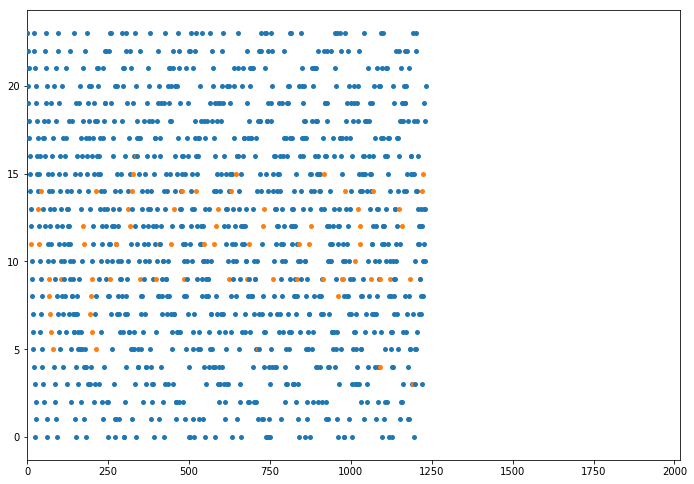

In [74]:
# dn = df_flag.loc[df_flag.price == 55]
# dfn = dn.groupby('day_of_week', as_index=False).reward.mean()

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.swarmplot(data = dn, x = 'max_diff_autocor', y = 'hour', hue = 'flag', ax=ax, )
# sns.lineplot(data = dfn, x = 'day_of_week', y = 'reward', ax=ax, color = 'green')

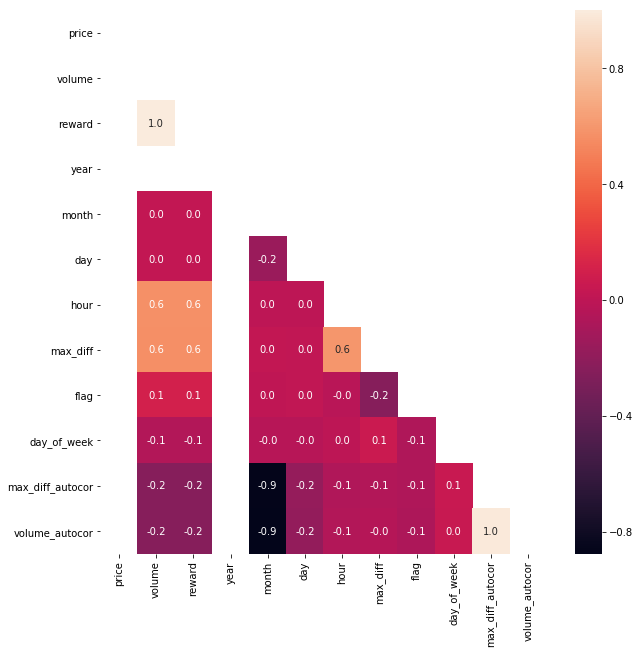

In [75]:
mask = np.zeros_like(dn.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(dn.corr(), mask = mask, annot=True, fmt= '.1f', ax = ax)

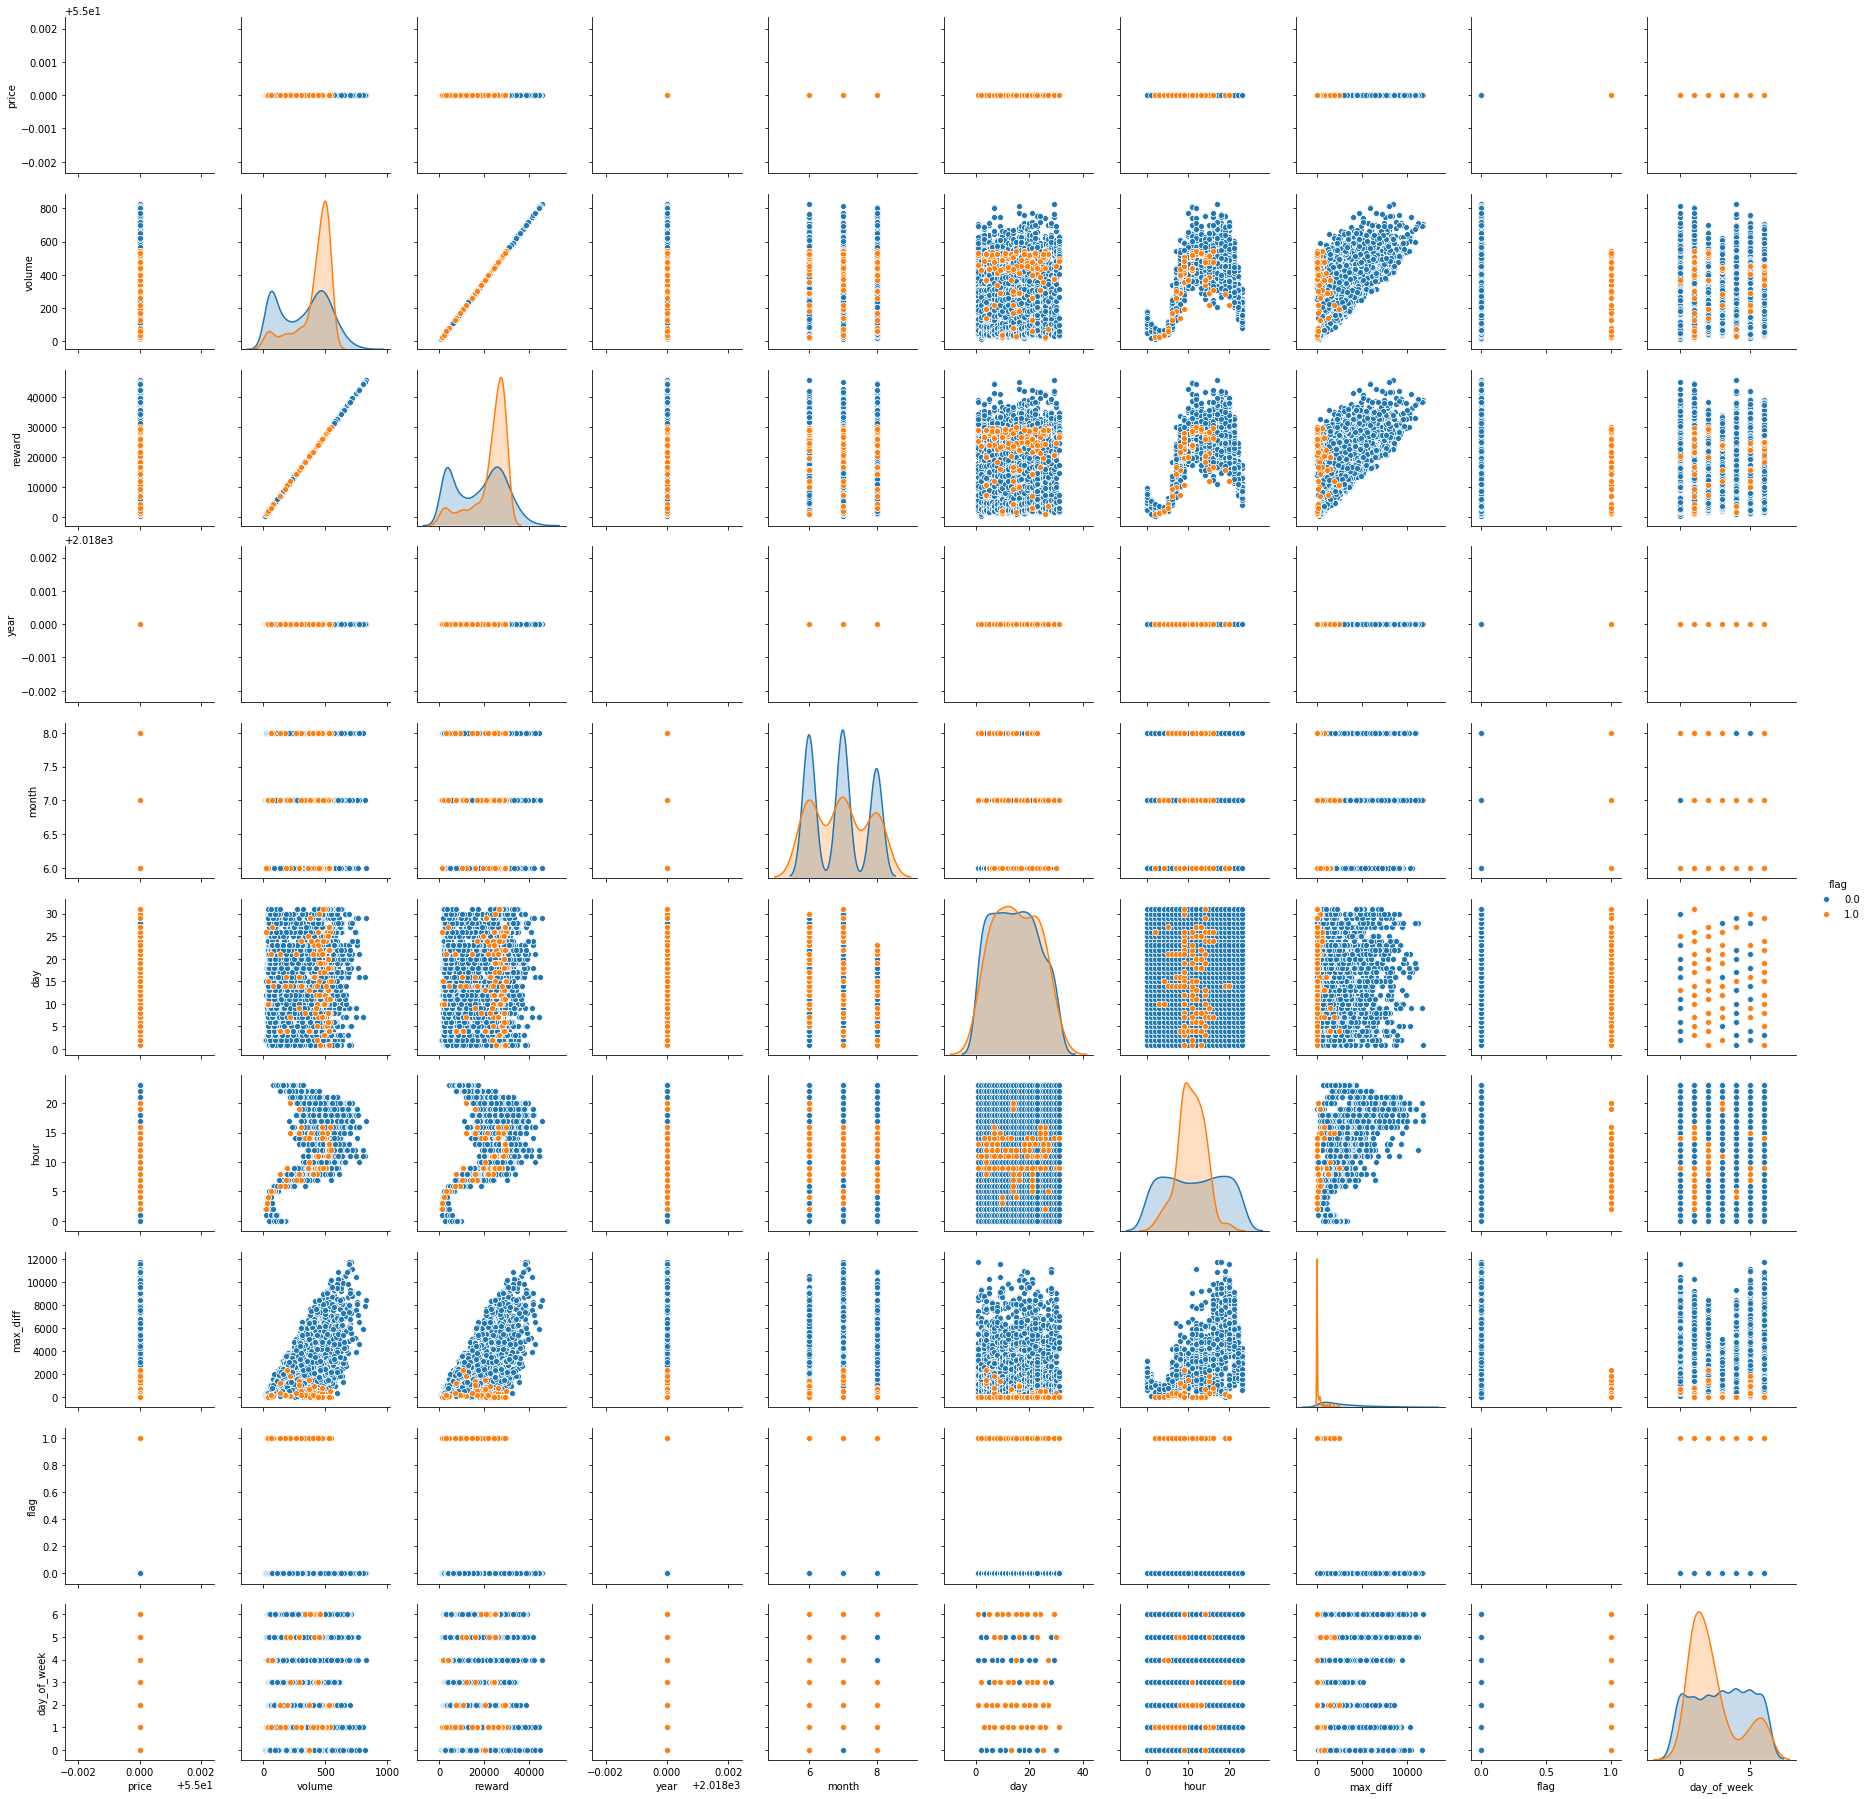

In [37]:
sns.pairplot(data = dn.drop(columns = ['date_time']), hue= 'flag')

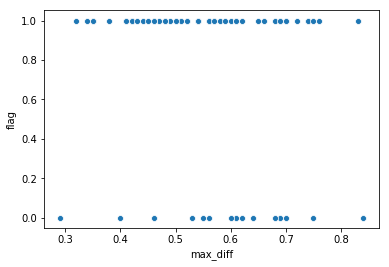

In [467]:
dn = df_flag.loc[:, ['max_diff', 'flag']].drop_duplicates()
dfff = dfff.loc[dfff.max_diff < 1]
dn['pred_max_diff'] = np.roll(dn.max_diff.values, 1)

dn.drop(0, inplace = True)

sns.scatterplot(dn.max_diff, dfff.flag)

In [230]:
X.groupby('date_time').reward.max().sum()

36665035.2

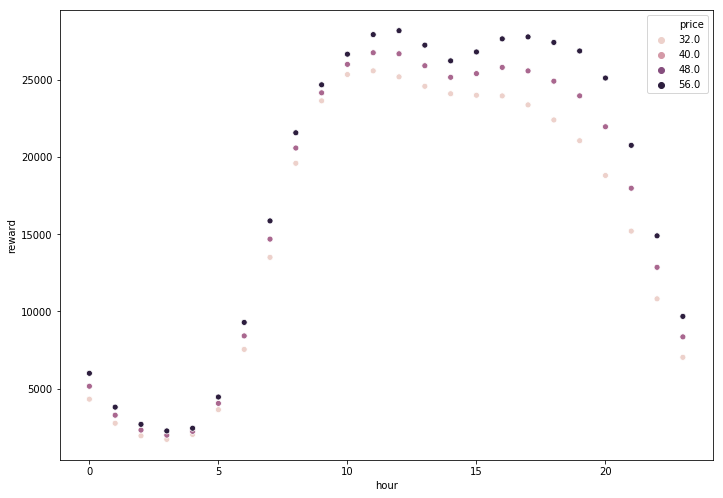

In [175]:
grouped = X.groupby(['price', 'hour'], as_index=False)['reward'].mean()

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.scatterplot(data = grouped.loc[grouped.price.isin([35, 45, 55])], x ='hour', y='reward', hue = 'price', ax = ax)